<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S7/Session_7_Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolution block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3), # 16,26,26
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3), # 32,24,24
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.10)
        )
        # transition block 1
        self.trans_block1 = nn.Sequential(
            nn.MaxPool2d(2, 2), # 32,12,12 - reduce output
            nn.Conv2d(32, 16, 1), # 16,12,12 - reduce channels
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # convolution block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3), # 32,10,10
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3), # 64,8,8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.10)
        )

        # transition block 2
        self.trans_block2 = nn.Sequential(
            nn.MaxPool2d(2, 2), # 64,4,4 - reduce output
            nn.Conv2d(64, 32, 1), # 32,4,4 - reduce channels
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # final block
        self.final_block = nn.Sequential(
            nn.Conv2d(32, 10, 1), # 10,4,4
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(10, 10, 4)  # 10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans_block1(x)
        x = self.conv2(x)
        x = self.trans_block2(x)
        x = self.final_block(x)
        x = x.view(-1,10)
        return F.log_softmax(x, dim=-1)

In [14]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
           Dropout-7           [-1, 32, 24, 24]               0
         MaxPool2d-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 16, 12, 12]             528
      BatchNorm2d-10           [-1, 16, 12, 12]              32
             ReLU-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 32, 10, 10]           4,640
      BatchNorm2d-13           [-1, 32, 10, 10]              64
             ReLU-14           [-1, 32,

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07430058717727661 Batch_id=468 Accuracy=94.67: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0545, Accuracy: 9848/10000 (98.48%)

EPOCH: 1


Loss=0.15146096050739288 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]



Test set: Average loss: 0.0373, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.01692088134586811 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.015213832259178162 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0267, Accuracy: 9913/10000 (99.13%)

EPOCH: 4


Loss=0.07338707149028778 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:18<00:00, 24.87it/s]



Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.020038574934005737 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]



Test set: Average loss: 0.0256, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.005515644792467356 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:19<00:00, 24.62it/s]



Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.002204782562330365 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]



Test set: Average loss: 0.0242, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.014936721883714199 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.0010556891793385148 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.004325332120060921 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]



Test set: Average loss: 0.0236, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.003662648843601346 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:17<00:00, 26.73it/s]



Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.0010821635369211435 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.0015517892315983772 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]



Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.001973695820197463 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0219, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

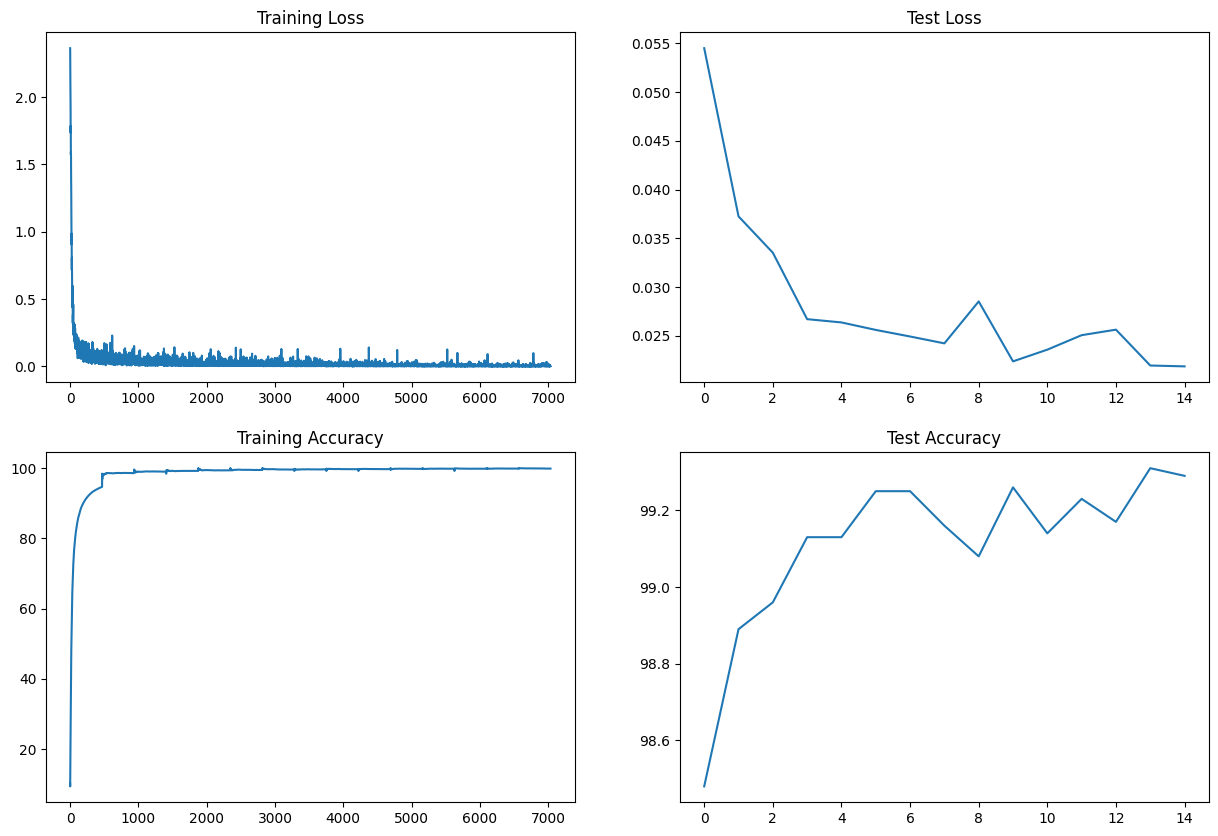

In [17]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")